# Import Library

This notebook contains a convolutional neural network model in TensorFlow and leverage Keras' utilities for agumenting image data and create the model. We also will use os module to manipulate the images file, numpy and matplotlib module to visualize the images.

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, concatenate
from keras.optimizers import Adam
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.preprocessing import image
import numpy as np
from keras.models import load_model

The images are stored in `Datasets` folder and there is subfolder for each features. Here we are counting the total of the images that will be used to train and test the model.

In [2]:
# Definisikan path ke direktori data
base_dir = 'Datasets'
features = ['scenery', 'environment', 'category']

# Fungsi untuk menghitung jumlah file dalam direktori
def count_files_in_directory(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len([file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.webp'))])
    return total_files

# Menghitung jumlah file untuk setiap fitur dan labela
for feature in features:
    feature_dir = os.path.join(base_dir, feature)
    print(f'Output: {feature}')
    for label in os.listdir(feature_dir):
        label_dir = os.path.join(feature_dir, label)
        if os.path.isdir(label_dir):
            num_files = count_files_in_directory(label_dir)
            print(f'  Label: {label}, Number of files: {num_files}')


Output: scenery
  Label: nature, Number of files: 900
  Label: urban, Number of files: 900
Output: environment
  Label: land, Number of files: 900
  Label: water, Number of files: 900
Output: category
  Label: attractions, Number of files: 900
  Label: historical, Number of files: 900
  Label: greenery, Number of files: 900


# Data Pre-Processing

In [3]:
sce_dir = os.path.join(base_dir, 'scenery')
env_dir = os.path.join(base_dir, 'environment')
cat_dir = os.path.join(base_dir, 'category')

Below we fed Keras' `ImageDataGenerator` using the images and it will yield batches of images, both for training and validation using `validation_split` parameter. We also use `flow_from_directory` method to standarize the images' resolution by defining a tuple called `target_size` of (224, 224).

In [4]:
# Tentukan ukuran gambar yang diinginkan
img_width, img_height = 224, 224
batch_size = 32

# Fungsi untuk membuat generator dengan data augmentation
def create_gen(base_dir, img_width, img_height, batch_size, subset):
    if subset == 'training':
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=45,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            brightness_range=[0.8, 1.2],
            validation_split=0.2
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    generator = datagen.flow_from_directory(
        base_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset=subset,
        shuffle=True)
    return generator

# Membuat generator untuk setiap fitur
sce_train_gen = create_gen(sce_dir, img_width, img_height, batch_size, 'training')
env_train_gen = create_gen(env_dir, img_width, img_height, batch_size, 'training')
cat_train_gen = create_gen(cat_dir, img_width, img_height, batch_size, 'training')

sce_val_gen = create_gen(sce_dir, img_width, img_height, batch_size, 'validation')
env_val_gen = create_gen(env_dir, img_width, img_height, batch_size, 'validation')
cat_val_gen = create_gen(cat_dir, img_width, img_height, batch_size, 'validation')

Found 1437 images belonging to 2 classes.
Found 1417 images belonging to 2 classes.
Found 2133 images belonging to 3 classes.
Found 358 images belonging to 2 classes.
Found 353 images belonging to 2 classes.
Found 532 images belonging to 3 classes.


Now we take a look at a sample image of each one of the label in each features.

In [5]:
def show_example_images(generator, images_per_class=1):
    class_indices = generator.class_indices
    class_names = list(class_indices.keys())
    
    images, labels = next(generator)

    # Create a list to store selected images and their corresponding labels
    selected_images = []
    selected_labels = []

    # Iterate through each class and select a specified number of images
    for class_name in class_names:
        class_index = class_indices[class_name]
        class_images = [img for img, lbl in zip(images, labels) if np.argmax(lbl) == class_index]
        class_labels = [lbl for lbl in labels if np.argmax(lbl) == class_index]

        # If there are fewer images than requested, use all available images
        if len(class_images) < images_per_class:
            selected_images.extend(class_images)
            selected_labels.extend(class_labels)
        else:
            selected_indices = random.sample(range(len(class_images)), images_per_class)
            selected_images.extend([class_images[idx] for idx in selected_indices])
            selected_labels.extend([class_labels[idx] for idx in selected_indices])

    num_images = len(selected_images)
    
    # Plot the images
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(selected_images[i])
        plt.axis("off")

        class_index = np.argmax(selected_labels[i])
        class_name = class_names[class_index]

        plt.title(class_name, fontsize=12)
    
    plt.show()

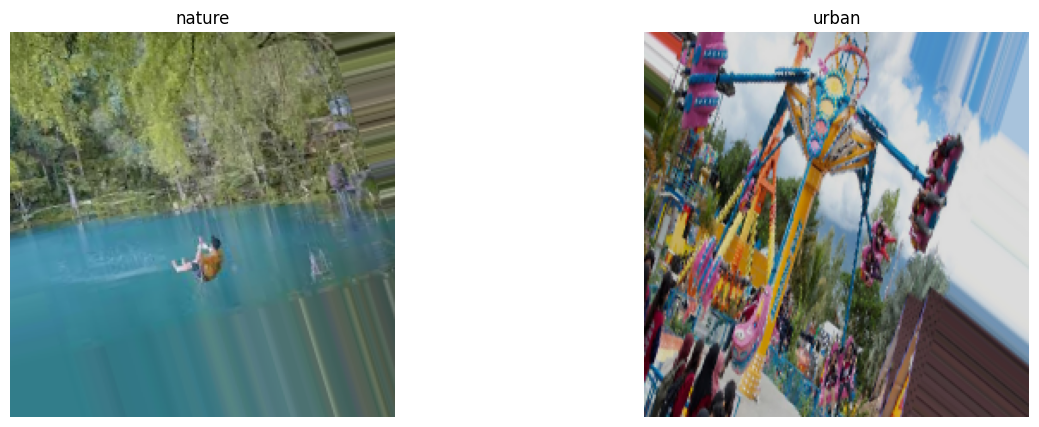

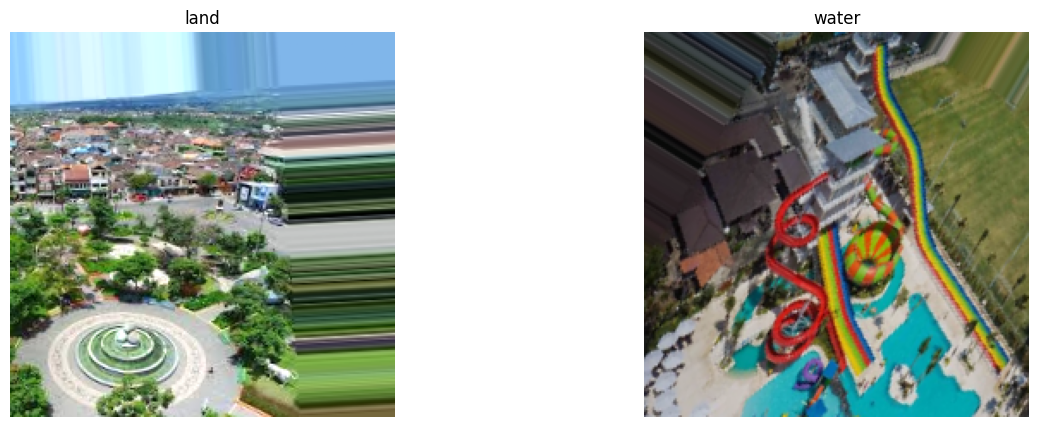

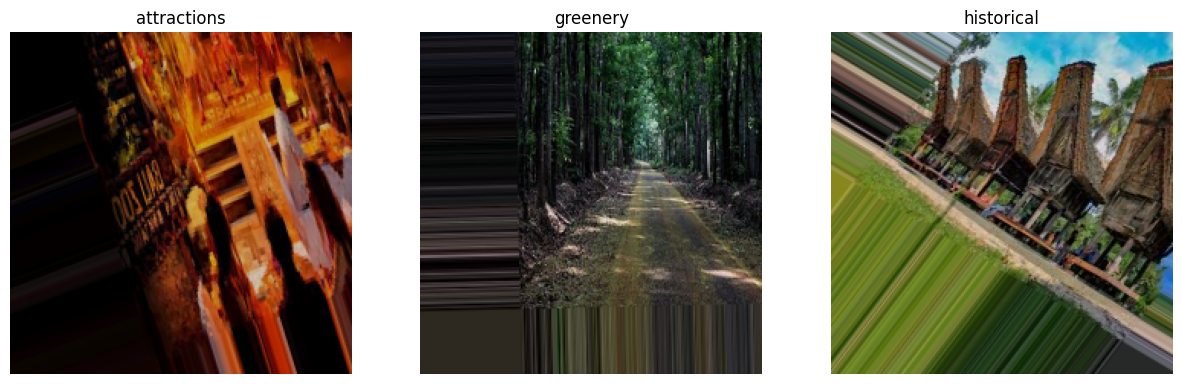

In [6]:
# Menampilkan contoh gambar dari train_generator
show_example_images(sce_train_gen, images_per_class=1)  
show_example_images(env_train_gen, images_per_class=1)  
show_example_images(cat_train_gen, images_per_class=1)  


# Model Architecture

Below are the defined architecture of pre-trained model using `MobileNetV2` with the input shape of (224, 224, 3). We pipeline it with our own model by adding some additional layers on top of the pre-trained model. The output of the final model is 3 where each output has either two or three units using `sigmoid` activation. Lastly, we compile the model by defining the optimizer and loss function.

In [7]:
base_model = MobileNetV2(include_top=False, input_shape=(img_width, img_height, 3), weights='imagenet')

# Unfreeze some of the layers in the base model
for layer in base_model.layers[-50:]:
    layer.trainable = True

inputs = Input(shape=(img_width, img_height, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)

# Output scenery
scenery = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
scenery = Dropout(0.5)(scenery)
scenery = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(scenery)
scenery = Dropout(0.5)(scenery)
scenery = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(scenery)
scenery = Dropout(0.5)(scenery)
scenery_output = Dense(2, activation='sigmoid', name='scenery')(scenery)

# Output environment
environment = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
environment = Dropout(0.5)(environment)
environment = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(environment)
environment = Dropout(0.5)(environment)
environment = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(environment)
environment = Dropout(0.5)(environment)
environment_output = Dense(2, activation='sigmoid', name='environment')(environment)

# Output category
category = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
category = Dropout(0.5)(category)
category = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(category)
category = Dropout(0.5)(category)
category = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(category)
category = Dropout(0.5)(category)
category_output = Dense(3, activation='sigmoid', name='category')(category)

sce_model = Model(inputs=inputs, outputs=scenery_output)
env_model = Model(inputs=inputs, outputs=environment_output)
cat_model = Model(inputs=inputs, outputs=category_output)

# Compile the model with a different learning rate
learning_rate = 0.0001

sce_opt = Adam(learning_rate=learning_rate)
env_opt = Adam(learning_rate=learning_rate)
cat_opt = Adam(learning_rate=learning_rate)

sce_model.compile(optimizer=sce_opt,
              loss={'scenery': 'binary_crossentropy'},
              metrics={'scenery': 'accuracy'})
env_model.compile(optimizer=env_opt,
              loss={'environment': 'binary_crossentropy'},
              metrics={'environment': 'accuracy'})
cat_model.compile(optimizer=cat_opt,
              loss={'category': 'categorical_crossentropy'},
              metrics={'category': 'accuracy'})



9406464/9406464 [==============================] - 1s 0us/step


In [8]:
sce_model.summary()
env_model.summary()
cat_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0     

# Training the Model

Before training the model, we defined callbacks using `EarlyStopping` and `ReduceLROnPlateau` to prevent it from overfitting then train each feature.

In [9]:
# Adding callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


scenery_history = sce_model.fit(
    sce_train_gen,
    validation_data=sce_val_gen,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Train environment output
environment_history = env_model.fit(
    env_train_gen,
    validation_data=env_val_gen,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Train category output
category_history = cat_model.fit(
    cat_train_gen,
    validation_data=cat_val_gen,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20


45/45 [==============================] - 89s 2s/step - loss: 23.6975 - accuracy: 0.6256 - val_loss: 22.0862 - val_accuracy: 0.9134 - lr: 1.0000e-04
Epoch 2/20
45/45 [==============================] - 67s 1s/step - loss: 20.7078 - accuracy: 0.9005 - val_loss: 19.2545 - val_accuracy: 0.9469 - lr: 1.0000e-04
Epoch 3/20
45/45 [==============================] - 57s 1s/step - loss: 18.0895 - accuracy: 0.9478 - val_loss: 16.8433 - val_accuracy: 0.9469 - lr: 1.0000e-04
Epoch 4/20
45/45 [==============================] - 57s 1s/step - loss: 15.7521 - accuracy: 0.9596 - val_loss: 14.6203 - val_accuracy: 0.9609 - lr: 1.0000e-04
Epoch 5/20
45/45 [==============================] - 57s 1s/step - loss: 13.6417 - accuracy: 0.9638 - val_loss: 12.5870 - val_accuracy: 0.9888 - lr: 1.0000e-04
Epoch 6/20
45/45 [==============================] - 57s 1s/step - loss: 11.7231 - accuracy: 0.9833 - val_loss: 10.8620 - val_accuracy: 0.9637 - lr: 1.0000e-04
Epoch 7/20
45/45 [==========================

# Evaluation and Save the Model

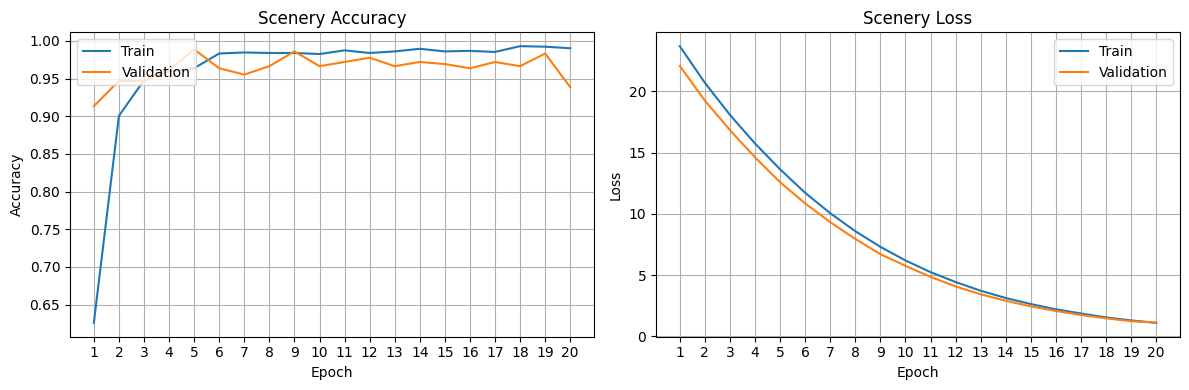

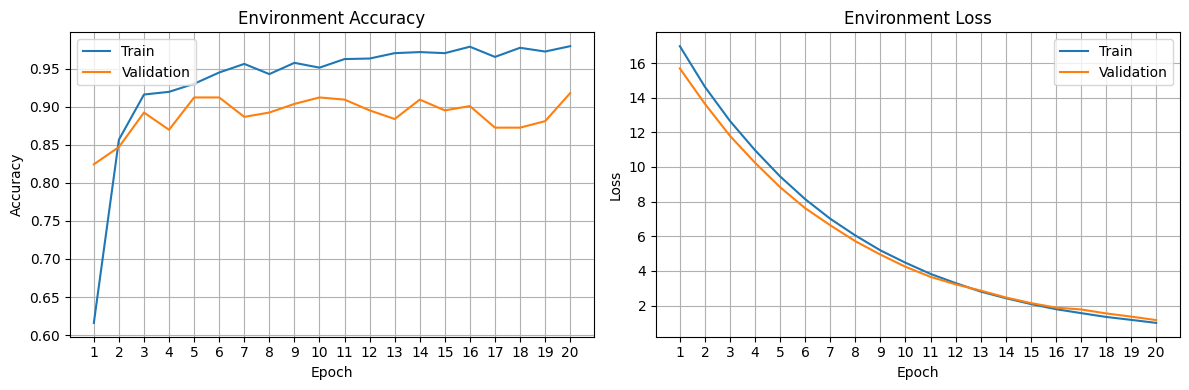

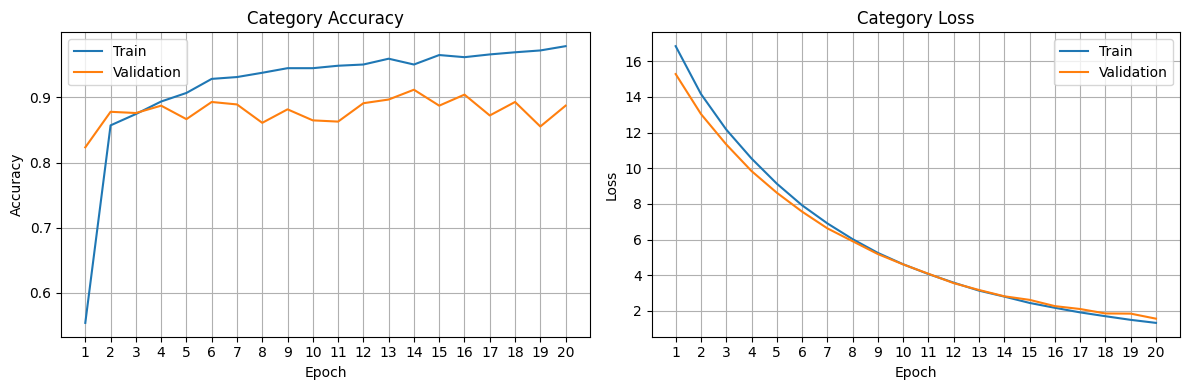

In [19]:
# Function to plot training history
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))

    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epoch numbers
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epoch numbers
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plotting for scenery model
plot_training_history(scenery_history, 'Scenery')

# Plotting for environment model
plot_training_history(environment_history, 'Environment')

# Plotting for category model
plot_training_history(category_history, 'Category')


In [1]:
# Function to print the last accuracy, validation accuracy, loss, and validation loss
def print_last_metrics(history, title):
    last_acc = history.history['accuracy'][-1]
    last_val_acc = history.history['val_accuracy'][-1]
    last_loss = history.history['loss'][-1]
    last_val_loss = history.history['val_loss'][-1]
    
    print(f'{title} - Last Epoch Metrics:')
    print(f'Accuracy: {last_acc:.4f}')
    print(f'Validation Accuracy: {last_val_acc:.4f}')
    print(f'Loss: {last_loss:.4f}')
    print(f'Validation Loss: {last_val_loss:.4f}')
    print()

# Printing last metrics for each model
print_last_metrics(scenery_history, 'Scenery')
print_last_metrics(environment_history, 'Environment')
print_last_metrics(category_history, 'Category')


NameError: name 'scenery_history' is not defined

## SaveModel

Here we save the model of each features using TensorFlow SavedModel format.

In [11]:
import tensorflow as tf

# Assuming you have trained your models with model.fit()

# Save scenery model
tf.saved_model.save(sce_model, 'ModelEviden/scenery_model')

# Save environment model
tf.saved_model.save(env_model, 'ModelEviden/environment_model')

# Save category model
tf.saved_model.save(cat_model, 'ModelEviden/category_model')


INFO:tensorflow:Assets written to: ModelEviden/scenery_model\assets


INFO:tensorflow:Assets written to: ModelEviden/scenery_model\assets


INFO:tensorflow:Assets written to: ModelEviden/environment_model\assets


INFO:tensorflow:Assets written to: ModelEviden/environment_model\assets


INFO:tensorflow:Assets written to: ModelEviden/category_model\assets


INFO:tensorflow:Assets written to: ModelEviden/category_model\assets


## Keras & h5

Saving the model into .keras and .h5 format using `save()` function provided by TensorFlow.

In [12]:
# Save scenery model
sce_model.save("ModelEviden/sce_model.keras")

# Save environment model
env_model.save("ModelEviden/env_model.keras")

# Save category model
cat_model.save("ModelEviden/cat_model.keras")

# Save scenery model
sce_model.save("ModelEviden/sce_model.h5")

# Save environment model
env_model.save("ModelEviden/env_model.h5")

# Save category model
cat_model.save("ModelEviden/cat_model.h5")

c:\Users\User 2\.conda\envs\wishata\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Combined the three models of each feature into one model and save it using save() function.

In [13]:
# Define input layer

img_width, img_height = 224,224
input_layer = Input(shape=(img_width, img_height, 3))

# Get the outputs from each individual model
scenery_output = sce_model(input_layer)
environment_output = env_model(input_layer)
category_output = cat_model(input_layer)

# Combine the outputs into a single list
combined_outputs = [scenery_output, environment_output, category_output]

# Create the combined model
combined_model = Model(inputs=input_layer, outputs=combined_outputs)

# Compile the combined model
# You need to define appropriate loss functions and metrics for each output
combined_model.compile(optimizer='adam', 
                       loss=['binary_crossentropy', 'binary_crossentropy', 'categorical_crossentropy'],
                       metrics=['accuracy', 'accuracy', 'accuracy'])

# Summary of the combined model
combined_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 2)                    4095810   ['input_3[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 2)                    4095810   ['input_3[0][0]']             
                                                                                                  
 model_2 (Functional)        (None, 3)                    4096067   ['input_3[0][0]']             
                                                                                            

In [14]:
combined_model.save("ModelEviden/combined_model.keras")
combined_model.save("ModelEviden/combined_model.h5")

Evaluate the combined model that has been saved before with one test images. The output should be three features where the test image will be classified into one label in each features.

1/1 [==============================] - 3s 3s/step
Scenery Prediction: [[0.3290554 0.6667215]]
Environment Prediction: [[0.7460724  0.26265764]]
Category Prediction: [[0.36889532 0.34005222 0.8540209 ]]


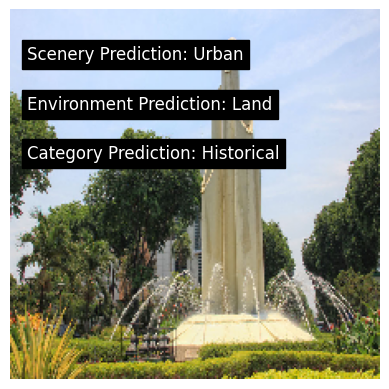

In [15]:
loaded_combined_model = load_model("ModelEviden/combined_model.h5")
# Load an example image from the dataset
image_path = "Test/test1.jpg" 
test_image = image.load_img(image_path, target_size=(img_width, img_height))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

# Preprocess the image
test_image = test_image / 255.0  # Normalize pixel values to [0, 1]

# Make predictions using the combined model
predictions = loaded_combined_model.predict(test_image)

# Interpret the predictions
scenery_prediction = predictions[0]  # Output for scenery
environment_prediction = predictions[1]  # Output for environment
category_prediction = predictions[2]  # Output for category

# Example: Print the predicted labels
print("Scenery Prediction:", scenery_prediction)
print("Environment Prediction:", environment_prediction)
print("Category Prediction:", category_prediction)

# Define the class labels for interpretation
scenery_classes = ['Nature', 'Urban']
environment_classes = ['Land', 'Water']
category_classes = ['Attraction', 'Greenery', 'Historical']

# Show the image
plt.imshow(test_image[0])
plt.axis('off')

# Add text annotations for predictions
scenery_label = scenery_classes[np.argmax(scenery_prediction)]
environment_label = environment_classes[np.argmax(environment_prediction)]
category_label = category_classes[np.argmax(category_prediction)]

plt.text(10, 30, f"Scenery Prediction: {scenery_label}", fontsize=12, color='white', backgroundcolor='black')
plt.text(10, 60, f"Environment Prediction: {environment_label}", fontsize=12, color='white', backgroundcolor='black')
plt.text(10, 90, f"Category Prediction: {category_label}", fontsize=12, color='white', backgroundcolor='black')

plt.show()



# Convert to TFLite

Lastly, convert each of the three features model that have been stored with `saved_model` into TensorFlow Lite using `tf.lite.TFLiteConverter`.

In [16]:
model = tf.keras.models.load_model('ModelEviden/sce_model.keras')

model.summary()
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # TensorFlow Lite builtin operations
    tf.lite.OpsSet.SELECT_TF_OPS     # TensorFlow operations
]
converter.experimental_new_converter = True

try:
    tflite_model = converter.convert()
    # Save the converted model
    with open("ModelEviden/sce_model.tflite", "wb") as f:
        f.write(tflite_model)
    print("Model conversion successful.")
except Exception as e:
    print("Error during model conversion:", str(e))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0     

INFO:tensorflow:Assets written to: C:\Users\USER2~1\AppData\Local\Temp\tmp56xv1wq1\assets


Model conversion successful.


In [17]:
model = tf.keras.models.load_model('ModelEviden/env_model.keras')

model.summary()
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # TensorFlow Lite builtin operations
    tf.lite.OpsSet.SELECT_TF_OPS     # TensorFlow operations
]
converter.experimental_new_converter = True

try:
    tflite_model = converter.convert()
    # Save the converted model
    with open("ModelEviden/env_model.tflite", "wb") as f:
        f.write(tflite_model)
    print("Model conversion successful.")
except Exception as e:
    print("Error during model conversion:", str(e))


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0   

INFO:tensorflow:Assets written to: C:\Users\USER2~1\AppData\Local\Temp\tmp667qoim2\assets


Model conversion successful.


In [18]:
model = tf.keras.models.load_model('ModelEviden/cat_model.keras')

model.summary()
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # TensorFlow Lite builtin operations
    tf.lite.OpsSet.SELECT_TF_OPS     # TensorFlow operations
]
converter.experimental_new_converter = True

try:
    tflite_model = converter.convert()
    # Save the converted model
    with open("ModelEviden/cat_model.tflite", "wb") as f:
        f.write(tflite_model)
    print("Model conversion successful.")
except Exception as e:
    print("Error during model conversion:", str(e))


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_7 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0   

INFO:tensorflow:Assets written to: C:\Users\USER2~1\AppData\Local\Temp\tmpfpy9hbos\assets


Model conversion successful.
